# Telco Churn Prediction

<p>Telco is a <strong>fictional company</strong> that provided <strong>home phone and Internet services</strong> to <strong>7043 customers</strong> in <strong>California in Q3</strong>. It indicates <strong>which customers have left or stayed</strong>. Multiple important <strong>demographics</strong> are included for each customer, as well as a <strong>Churn Score and Customer Lifetime Value (CLTV) index</strong>.</p>

<p>We aim to understand first if Telco's business is in good health. We will have an overview of their <strong>customers profile</strong>, and will <strong>deep dive the "Churners" category</strong> to understand why they left.</p>

<p>With the help of this analysis, we will then attempt to improve the <strong>customer churn prediction</strong> in order to <strong>better allocate marketing spendings</strong> at Telco.</p>

In [1]:
# import required packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


# import dataset and read the 5 first lines
telco = pd.read_excel("dataset/telco_customer_churn.xlsx")
telco.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [2]:
# display the type of each column of the dataframe
telco.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
Churn Reason          object
dtype: object

In [3]:
# Search for columns with missing values
telco.isnull().any()

CustomerID           False
Count                False
Country              False
State                False
City                 False
Zip Code             False
Lat Long             False
Latitude             False
Longitude            False
Gender               False
Senior Citizen       False
Partner              False
Dependents           False
Tenure Months        False
Phone Service        False
Multiple Lines       False
Internet Service     False
Online Security      False
Online Backup        False
Device Protection    False
Tech Support         False
Streaming TV         False
Streaming Movies     False
Contract             False
Paperless Billing    False
Payment Method       False
Monthly Charges      False
Total Charges        False
Churn Label          False
Churn Value          False
Churn Score          False
CLTV                 False
Churn Reason          True
dtype: bool

<p>From the previous results, we notice that:</p>
<ul>
    <li><strong>"Total Charges"</strong> is imported as "string". However, this column should be of type 'float'. This implies that some values may not be numbers, let's look for them.</li><br>
<li><strong>"Zip Code"</strong> is interpreted as "integer". We should convert it to "string" to prevent calculations on this field.</li><br>
<li>Only <strong>"Churn Reason"</strong> has got missing values. It seems normal for this column as a non-churner would not have any churn reason.</li>
</ul>

In [4]:
# set an empty list to retrieve CustomerID with a corrupted value in Total Charges
not_number = []

# loop over each row of telco dataframe
for index, row in telco.iterrows():
    # save the CustomerID in a variable
    customer = telco.loc[index, "CustomerID"]
    # check if the Total Charges value x is of type "int" or "float"
    x = telco.loc[index, "Total Charges"]
    check_type = isinstance(x, (float, int))
    # if not, add CustomerID to the list
    if not check_type:
        not_number.append(customer)

# print the list of CustomerID with a corrupted value in Total Charges
print("Here is the list of the concerned customers:\n")
print(not_number)
print()

# create a dataframe with the concerned CustomerID to see how the values look like
wrong_totalcharges = telco["CustomerID"].isin(not_number)
telco_filtered = telco.loc[wrong_totalcharges, ["CustomerID", "Tenure Months", "Total Charges"]]
telco_filtered

Here is the list of the concerned customers:

['4472-LVYGI', '3115-CZMZD', '5709-LVOEQ', '4367-NUYAO', '1371-DWPAZ', '7644-OMVMY', '3213-VVOLG', '2520-SGTTA', '2923-ARZLG', '4075-WKNIU', '2775-SEFEE']



,CustomerID,Tenure Months,Total Charges
2234,4472-LVYGI,0,
2438,3115-CZMZD,0,
2568,5709-LVOEQ,0,
2667,4367-NUYAO,0,
2856,1371-DWPAZ,0,
4331,7644-OMVMY,0,
4687,3213-VVOLG,0,
5104,2520-SGTTA,0,
5719,2923-ARZLG,0,
6772,4075-WKNIU,0,


As no missing values were identified in the "Total Charges" column, we can suspect unexpected white spaces. Let's have a look.

In [5]:
print("Here is the list of the corrupted values:\n")
print(telco_filtered["Total Charges"].tolist())

Here is the list of the corrupted values:

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


Indeed, we have got white spaces in this column. As all the concerned customers are new (Tenure Months = 0), we can interpret these white spaces as "0.0" for the Total Charges.

In [6]:
# setting wrong total charges to 0.0
telco.loc[wrong_totalcharges, ["Total Charges"]] = 0.0
display(telco.loc[wrong_totalcharges, ["CustomerID", "Total Charges"]])

# convert Total Charges column into float
telco["Total Charges"] = telco["Total Charges"].astype(float)
telco["Total Charges"].dtypes

,CustomerID,Total Charges
2234,4472-LVYGI,0
2438,3115-CZMZD,0
2568,5709-LVOEQ,0
2667,4367-NUYAO,0
2856,1371-DWPAZ,0
4331,7644-OMVMY,0
4687,3213-VVOLG,0
5104,2520-SGTTA,0
5719,2923-ARZLG,0
6772,4075-WKNIU,0


dtype('float64')

In [7]:
# convert Zip Code to string
telco["Zip Code"] = telco["Zip Code"].astype(str)

In [8]:
telco.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code              object
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
Churn Reason          object
dtype: object

## Data Exploration

In order to <strong>get some insights</strong> about Telco's customers, feel free to discover the <strong>data exploration</strong> I carried out using <strong>Tableau Public</strong>: https://public.tableau.com/views/TelcocustomerchurnIBMdataset/Histoire1?:language=fr&:display_count=y&:origin=viz_share_link

Please, also find my live presentation on YouTube (in french): https://youtu.be/VB7Oz4GTfOo?t=14

<AxesSubplot:xlabel='Churn Score', ylabel='CLTV'>

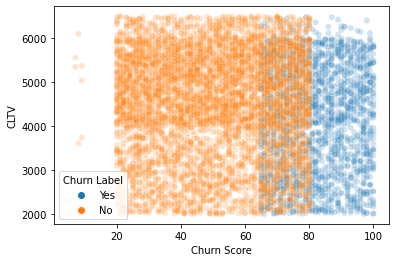

In [9]:
# Plot churners and non-churners regarding churn score and CLTV 
sns.scatterplot(x="Churn Score", y="CLTV", hue="Churn Label", data=telco, alpha=0.2)

It seems that every customer with a <strong>Churn Score higher or equal to 80 leaves</strong>, whereas one with <strong>a score lower than 60 stays</strong>. But <strong>a fuzzy area</strong> remains when the <strong>Churn Score is between 60 and 80</strong>. Let's help Telco and try to predict the churn risk of customers with a Churn Score in this interval.

No     1675
Yes     764
Name: Churn Label, dtype: int64



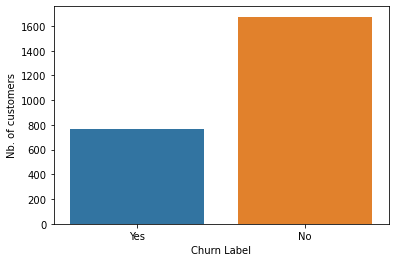

In [10]:
# filter customers on churn score betwwen 60 and 80
telco = telco[(telco["Churn Score"] >= 60) & (telco["Churn Score"] < 80)]

# count the number of churners
print(telco["Churn Label"].value_counts())
print()

# Plot the number of churners
sns.countplot(x = "Churn Label", data=telco)
plt.ylabel("Nb. of customers")
plt.show()

In [11]:
count_churners = len(telco[telco['Churn Label'] == "Yes"])
count_no_churners = len(telco[telco['Churn Label'] == "No"])

pct_of_churners = (count_churners / (count_churners + count_no_churners)) * 100

print(f"The Churners represent {round(pct_of_churners, 2)} % of our customer dataset for the studied quarter.\n")
print(f"{round(100 - pct_of_churners, 2)} % of Telco's customers remained loyal during the studied quarter.")

The Churners represent 31.32 % of our customer dataset for the studied quarter.

68.68 % of Telco's customers remained loyal during the studied quarter.


In [12]:
telco.groupby("Churn Label").mean()

,Count,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
Churn Label,,,,,,,,,
No,1.0,36.284745,-119.826431,38.017910,61.313164,2557.922985,0.0,69.645970,4482.423881
Yes,1.0,36.346076,-119.862979,16.807592,74.134293,1396.962958,1.0,71.981675,4138.068063


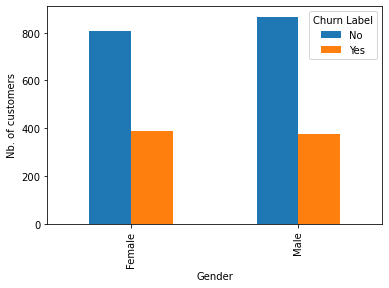

In [13]:
pd.crosstab(telco['Gender'], telco["Churn Label"]).plot(kind="bar")
plt.ylabel("Nb. of customers")
plt.show()

The number of Churners does not seem to depend on the gender. I do not think it is a good predictor of the outcome variable.

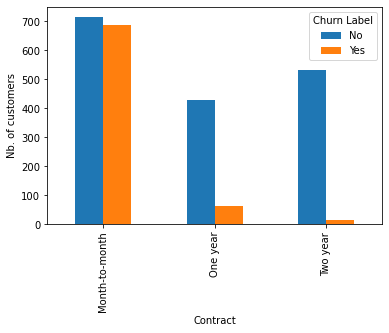

In [14]:
pd.crosstab(telco['Contract'], telco["Churn Label"]).plot(kind="bar")
plt.ylabel("Nb. of customers")
plt.show()

The number of churners seems to differ from a contract type to another. This can be a good predictor of our target variable.

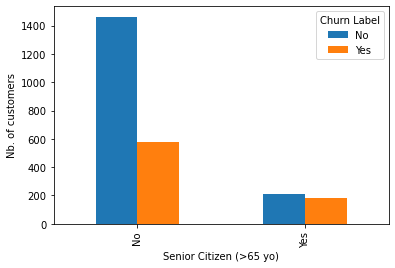

In [15]:
pd.crosstab(telco['Senior Citizen'], telco["Churn Label"]).plot(kind="bar")
plt.xlabel("Senior Citizen (>65 yo)")
plt.ylabel("Nb. of customers")
plt.show()

The age class of the customers can have an impact on the Churn, as it seems that almost the half of senior citizen customers left the company.

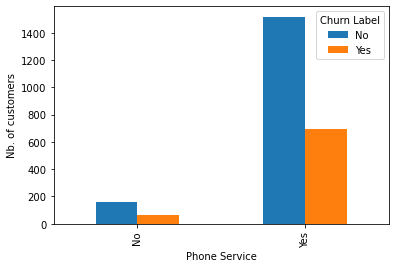

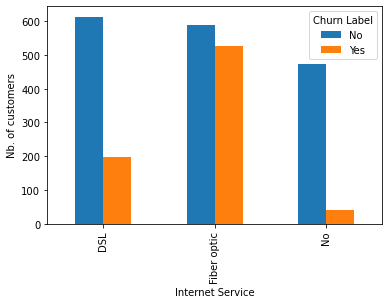

In [16]:
pd.crosstab(telco['Phone Service'], telco["Churn Label"]).plot(kind="bar")
plt.ylabel("Nb. of customers")
pd.crosstab(telco['Internet Service'], telco["Churn Label"]).plot(kind="bar")
plt.ylabel("Nb. of customers")
plt.show()

The subscribed services may also be a good predictor.

## Data preparation

<p>First, let's identify our features and the target variable.</p>

<strong>Features:</strong>
<ul>
    <li>Senior Citizen</li>
    <li>Tenure Months</li>
    <li>Phone Service</li>
    <li>Internet Service</li>
    <li>Contract</li>
    <li>Monthly Charges</li>
    <li>Total Charges</li>
    <li>Churn Score</li>
    <li>CLTV</li>
</ul>
<p><strong>Target variable:</strong> Churn Label (Yes, No)</p>

In [17]:
# define the features list
features_list = ["Senior Citizen", "Tenure Months", "Phone Service", "Internet Service",
                      "Contract", "Monthly Charges", "Total Charges", "Churn Score", "CLTV"]

# define the target variable
target_variable = "Churn Value"

In [18]:
# dummification of our features
dummy_features = pd.get_dummies(telco[features_list], drop_first=True)
dummy_features

,Tenure Months,Monthly Charges,Total Charges,Churn Score,CLTV,Senior Citizen_Yes,Phone Service_Yes,Internet Service_Fiber optic,Internet Service_No,Contract_One year,Contract_Two year
1,2,70.70,151.65,67,2701,0,1,1,0,0,0
5,10,55.20,528.35,78,5925,0,1,0,0,0,0
8,47,99.35,4749.15,77,5789,0,1,1,0,0,0
10,17,64.70,1093.10,74,3022,0,1,0,0,0,0
11,5,69.70,316.90,66,2454,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7029,18,95.05,1679.40,60,4524,0,1,1,0,0,0
7030,13,73.35,931.55,65,4645,0,1,0,0,0,0
7032,6,44.40,263.05,71,4611,1,0,0,0,0,0
7034,55,60.00,3316.10,71,4212,1,1,0,0,1,0


In [19]:
# Set features and target variable to numpy arrays

X = dummy_features.to_numpy()
y = telco[target_variable].to_numpy()

print(X)
print()
print(y)

[[2.00000e+00 7.07000e+01 1.51650e+02 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+01 5.52000e+01 5.28350e+02 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [4.70000e+01 9.93500e+01 4.74915e+03 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 ...
 [6.00000e+00 4.44000e+01 2.63050e+02 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [5.50000e+01 6.00000e+01 3.31610e+03 ... 0.00000e+00 1.00000e+00
  0.00000e+00]
 [7.20000e+01 1.03200e+02 7.36290e+03 ... 0.00000e+00 1.00000e+00
  0.00000e+00]]

[1 1 1 ... 0 0 0]


In [20]:
# Normalize X
scaler = StandardScaler()

X = scaler.fit_transform(X)
X

array([[-1.21823258,  0.17985766, -0.93186799, ..., -0.51736981,
        -0.50012812, -0.53832496],
       [-0.88644644, -0.33921639, -0.76001206, ..., -0.51736981,
        -0.50012812, -0.53832496],
       [ 0.64806443,  1.13930741,  1.16557724, ..., -0.51736981,
        -0.50012812, -0.53832496],
       ...,
       [-1.05233951, -0.70089378, -0.88104572, ..., -0.51736981,
        -0.50012812, -0.53832496],
       [ 0.97985057, -0.17847088,  0.51179934, ..., -0.51736981,
         1.99948764, -0.53832496],
       [ 1.68489611,  1.26823871,  2.35800736, ..., -0.51736981,
         1.99948764, -0.53832496]])

In [21]:
# Divide dataset Train set & Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Churn prediction using classification models

### K-Nearest Neighbors (KNN)

In [22]:
# Set the range of parameters to test
param_grid = {'n_neighbors': np.arange(1, 20),
             'metric': ['euclidean', 'manhattan']}

# specify a number of split for cross validation & fit the model to the training set
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [23]:
print(f"Best score: {grid.best_score_}\n")
print(f"It has been reached with the following parameters: {grid.best_params_}.")

Best score: 0.7959984261263033

It has been reached with the following parameters: {'metric': 'manhattan', 'n_neighbors': 17}.


In [24]:
# apply the best model on the test set
model = grid.best_estimator_
model.score(X_test, y_test)

0.7991803278688525

[[289  53]
 [ 45 101]]


<AxesSubplot:>

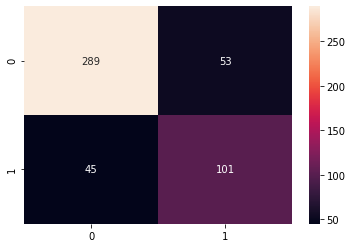

In [25]:
# create a confusion matrix to analyse the model's accuracy
y_pred = model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)
sns.heatmap(cf_matrix, annot=True, fmt="d")

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       342
           1       0.66      0.69      0.67       146

    accuracy                           0.80       488
   macro avg       0.76      0.77      0.76       488
weighted avg       0.80      0.80      0.80       488



[ 312  624  936 1248 1560]


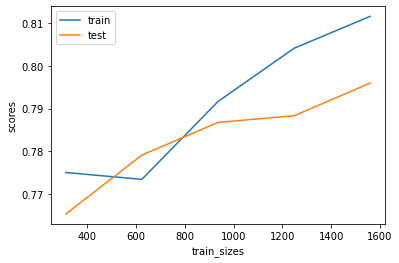

In [27]:
# create a learning curve
N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes = np.linspace(0.2, 1.0, 5), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='test')

plt.xlabel('train_sizes')
plt.ylabel('scores')
plt.legend()

# Logistic Regression

In [28]:
# Set the range of parameters to test
param_grid = {'penalty': ['l1', 'l2'],
             'C': np.logspace(-4, 4, 20),
             'solver': ['liblinear']}

# specify a number of split for cross validation & fit the model to the training set
grid = GridSearchCV(LogisticRegression(random_state=0), param_grid, cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [29]:
print(f"Best score: {grid.best_score_}\n")
print(f"It has been reached with the following parameters: {grid.best_params_}.")

Best score: 0.7893370057052922

It has been reached with the following parameters: {'C': 29.763514416313132, 'penalty': 'l1', 'solver': 'liblinear'}.


In [30]:
# apply the best model on the test set
model = grid.best_estimator_
model.score(X_test, y_test)

0.8176229508196722

[[298  44]
 [ 45 101]]


<AxesSubplot:>

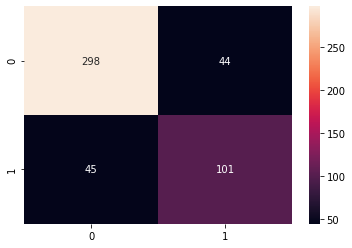

In [31]:
# create a confusion matrix to analyse the model's accuracy
y_pred = model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True, fmt="d")

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       342
           1       0.70      0.69      0.69       146

    accuracy                           0.82       488
   macro avg       0.78      0.78      0.78       488
weighted avg       0.82      0.82      0.82       488



,0
Churn Score,0.459055
Internet Service_Fiber optic,0.383983
Monthly Charges,0.249973
Total Charges,0.227268
Senior Citizen_Yes,0.164414
CLTV,0.042574
Phone Service_Yes,-0.156224
Contract_One year,-0.309706
Internet Service_No,-0.325495
Contract_Two year,-0.738674


<AxesSubplot:>

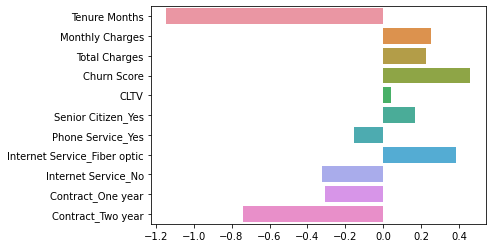

In [33]:
# Je récupère la liste de coef stocker dans le tableau numpy de dimension 1:1
importance = model.coef_[0]
dummy_features_list = dummy_features.columns.tolist()

df_importance = pd.DataFrame(data=importance, index = dummy_features_list)
df_importance = df_importance.sort_values(0, ascending=False)
display(df_importance)

# plot feature importance
sns.barplot(x=importance, y=dummy_features_list, data=df_importance)

[ 312  624  936 1248 1560]


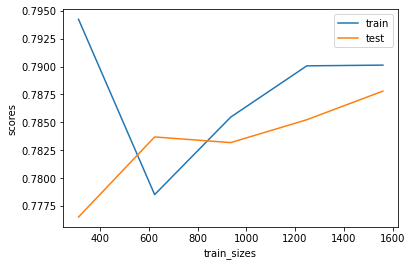

In [34]:
# create a learning curve
N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes = np.linspace(0.2, 1.0, 5), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='test')

plt.xlabel('train_sizes')
plt.ylabel('scores')
plt.legend()

# Random Forest

In [35]:
# Set the range of parameters to test
param_grid = {'n_estimators': list(range(10,201,10))}

# specify a number of split for cross validation & fit the model to the training set
grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200]})

In [36]:
print(f"Best score: {grid.best_score_}\n")
print(f"It has been reached with the following parameters: {grid.best_params_}.")

Best score: 0.8036881106957832

It has been reached with the following parameters: {'n_estimators': 80}.


In [37]:
# apply the best model on the test set
model = grid.best_estimator_
model.score(X_test, y_test)

0.8114754098360656

[[300  42]
 [ 50  96]]


<AxesSubplot:>

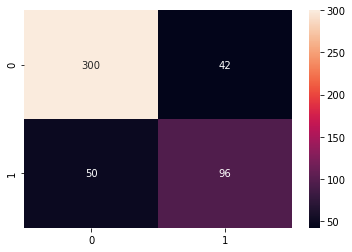

In [38]:
# create a confusion matrix to analyse the model's accuracy
y_pred = model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True, fmt="d")

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       342
           1       0.70      0.66      0.68       146

    accuracy                           0.81       488
   macro avg       0.78      0.77      0.77       488
weighted avg       0.81      0.81      0.81       488



In [40]:
dummy_features_list

['Tenure Months',
 'Monthly Charges',
 'Total Charges',
 'Churn Score',
 'CLTV',
 'Senior Citizen_Yes',
 'Phone Service_Yes',
 'Internet Service_Fiber optic',
 'Internet Service_No',
 'Contract_One year',
 'Contract_Two year']

In [41]:
model.feature_importances_

array([0.18827174, 0.15567414, 0.18096735, 0.1580967 , 0.141929  ,
       0.01508896, 0.00632455, 0.05381351, 0.02293018, 0.02823386,
       0.04867001])

,0
Tenure Months,0.188272
Total Charges,0.180967
Churn Score,0.158097
Monthly Charges,0.155674
CLTV,0.141929
Internet Service_Fiber optic,0.053814
Contract_Two year,0.048670
Contract_One year,0.028234
Internet Service_No,0.022930
Senior Citizen_Yes,0.015089


<AxesSubplot:>

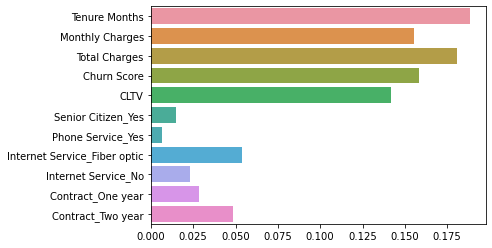

In [42]:
importance = model.feature_importances_

df_importance = pd.DataFrame(data=importance, index = dummy_features_list)
df_importance = df_importance.sort_values(0, ascending=False)
display(df_importance)

# plot feature importance
sns.barplot(x=importance, y=dummy_features_list, data=df_importance)

[ 312  624  936 1248 1560]


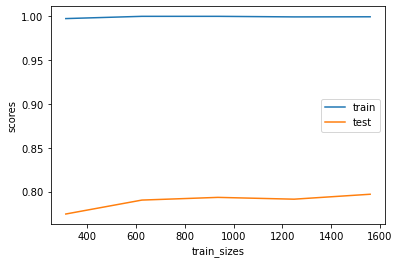

In [43]:
N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes = np.linspace(0.2, 1.0, 5), cv=5)
print(N)

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='test')

plt.xlabel('train_sizes')
plt.ylabel('scores')
plt.legend()

## Conclusion

<p>Logistic Regression is the model that better performed on this prediction with an accuracy of 0.82. This means that we managed to predict if a customer will churn or not in 82% of the cases.<br>
Furthermore, Logistic Regression is reaching the best combination of precision score (0.70) and recall score (0.69).</p>

<p>Nevertheless, the learning curve show that keeping adding values would enhance the model performances.</p>

<p>Finally, we meet some limits working with fictional data, as we harldy find real patterns and trends in our analysis. It could be interesting to apply this analysis on a concrete business, and try to tune more hyperparameters to improve our models prediction.</p>